# 인공지능적사고와문제해결 프로젝트2 8조

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import lightgbm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [36]:
# set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [37]:
# 예측한 값으로 성능을 평가하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1
    roc_auc = roc_auc_score(y_test, pred_proba) # ROC-AUC
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 데이터 전처리

In [38]:
vote_df = pd.read_csv("C:\\Users\\eunseo\\Desktop\\Git\\AI-project\\data\\train.csv", encoding="utf-8")
test_df = pd.read_csv("C:\\Users\\eunseo\\Desktop\\Git\\AI-project\\data\\test.csv", encoding="utf-8")
print("dataset shape: ", vote_df.shape)
print("dataset shape: ", test_df.shape)


dataset shape:  (36425, 78)
dataset shape:  (9107, 77)


In [39]:
# 인덱스 제거
vote_df.drop("index", axis=1, inplace=True)
test_index = test_df["index"]
test_df.drop("index", axis=1, inplace=True)

In [40]:
# 0값을 검사할 피처명 리스트 객체 설정
# zero_features = ['education', 'engnat', 'hand', 'urban']
# education 비율 맞추기?
zero_features = []

# tp 추가
for i in range(1, 11):
    s = 'tp' + chr(48+(i//10)) + chr(48+(i%10))
    zero_features.append(s)
    
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균 값으로 대체
vote_df[zero_features] = vote_df[zero_features].replace(0, vote_df[zero_features].mean())
test_df[zero_features] = test_df[zero_features].replace(0, test_df[zero_features].mean())

### 인코딩

In [41]:
# 레이블 인코딩
encoder = LabelEncoder()
encoder_test = LabelEncoder()

encoder.fit(vote_df['age_group'])
encoder_test.fit(test_df['age_group'])
labels = encoder.transform(vote_df['age_group'])
labels_test = encoder_test.transform(test_df['age_group'])

vote_df['age_group'] = labels
test_df['age_group'] = labels_test

def get_categoty_age(age_num):
    num = age_num;
    if age_num == 0: num =7

    return num

vote_df["age_group"] = vote_df["age_group"].apply(lambda x : get_categoty_age(x))
test_df["age_group"] = test_df["age_group"].apply(lambda x : get_categoty_age(x))

# 원핫 인코딩
def dummy_data(data, columns) :
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

dummy_columns = ['engnat', 'gender','hand', 'married', 'race', 'religion', 'urban']
# wr 추가
for i in range(1, 14):
    s = 'wr_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# wf 추가
for i in range(1, 4):
    s = 'wf_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# print(dummy_columns)

vote_df = dummy_data(vote_df, dummy_columns)
test_df = dummy_data(test_df, dummy_columns)


In [42]:
vote_df.head(5)

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,familysize,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,voted,engnat_0,engnat_1,engnat_2,gender_Female,gender_Male,hand_0,hand_1,hand_2,hand_3,married_0,married_1,married_2,married_3,race_Arab,race_Asian,race_Black,race_Indigenous Australian,race_Native American,race_Other,race_White,religion_Agnostic,religion_Atheist,religion_Buddhist,religion_Christian_Catholic,religion_Christian_Mormon,religion_Christian_Other,religion_Christian_Protestant,religion_Hindu,religion_Jewish,religion_Muslim,religion_Other,religion_Sikh,urban_0,urban_1,urban_2,urban_3,wr_01_0,wr_01_1,wr_02_0,wr_02_1,wr_03_0,wr_03_1,wr_04_0,wr_04_1,wr_05_0,wr_05_1,wr_06_0,wr_06_1,wr_07_0,wr_07_1,wr_08_0,wr_08_1,wr_09_0,wr_09_1,wr_10_0,wr_10_1,wr_11_0,wr_11_1,wr_12_0,wr_12_1,wr_13_0,wr_13_1,wf_01_0,wf_01_1,wf_02_0,wf_02_1,wf_03_0,wf_03_1
0,1.0,324,5.0,1067,5.0,359,1.0,709,1.0,742,1.0,330,5.0,541,5.0,1376,2.0,1397,5.0,1250,2.0,762,5.0,517,4.0,3614,1.0,521,5.0,705,4.0,633,1.0,330,1.0,512,5.0,347,5.0,588,2,3,2,2.000000,2.0000,1.000000,5.0,2.000000,4.0,5.000000,4.000000,1.00000,2.0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0
1,1.0,534,5.0,1555,5.0,2024,1.0,1097,1.0,3077,3.0,6721,1.0,1306,4.0,2968,5.0,1998,5.0,2756,2.0,3429,5.0,2395,5.0,1745,1.0,584,5.0,1857,5.0,2894,2.0,3761,1.0,2717,3.0,2802,5.0,1299,1,2,4,1.000000,2.6193,2.000000,2.0,1.333342,6.0,1.000000,5.000000,5.00000,6.0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0
2,5.0,609,1.0,749,2.0,624,1.0,1833,3.0,1474,5.0,728,4.0,1107,3.0,1743,5.0,3008,3.0,1649,5.0,870,1.0,1551,1.0,989,5.0,347,1.0,824,1.0,1445,2.0,884,5.0,744,1.0,899,4.0,963,2,2,3,3.018174,1.0000,1.755717,5.0,3.000000,6.0,2.022704,2.000000,1.00000,6.0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0
3,4.0,182,1.0,2969,1.0,1955,4.0,4630,1.0,1321,3.0,2345,4.0,850,1.0,3559,5.0,6761,1.0,8315,5.0,614,1.0,1751,1.0,1919,4.0,96,4.0,1251,5.0,261,4.0,548,4.0,2576,2.0,877,5.0,967,1,3,3,2.000000,2.0000,4.000000,5.0,1.333342,1.0,2.022704,2.000000,2.27234,4.0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0
4,4.0,549,5.0,1679,5.0,481,3.0,595,1.0,1202,1.0,348,1.0,422,2.0,2453,1.0,1051,5.0,4733,3.0,2705,5.0,773,4.0,775,2.0,1066,5.0,824,1.0,750,4.0,535,4.0,1000,4.0,964,5.0,683,2,2,4,6.000000,3.0000,6.000000,2.0,1.333342,6.0,2.000000,3.509952,6.00000,4.0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0


### 이상값 처리

In [43]:
# 시간 데이터 전처리

#Q_E 시간
Q_E = []
for i in range(97, 117):
    a = 'Q' + chr(i) + 'E'
    Q_E.append(a)

def get_categoty_time(Q_time):
    cat = 0
    if Q_time <= 1000 : cat = 1
    elif Q_time <= 2000 : cat = 2
    elif Q_time <= 3000 : cat = 3
    elif Q_time <= 4000 : cat = 4
    elif Q_time <= 5000 : cat = 5
    elif Q_time <= 6000 : cat = 6
    elif Q_time <= 7000 : cat = 7
    elif Q_time <= 8000 : cat = 8
    elif Q_time <= 9000 : cat = 9
    elif Q_time <=10000 : cat = 10
    elif Q_time <=15000 : cat = 11
    elif Q_time <=20000 : cat = 12
    else : Q_time = 13

    return cat

for Q_time in Q_E:
    vote_df[Q_time] = vote_df[Q_time].apply(lambda x : get_categoty_time(x))
    test_df[Q_time] = test_df[Q_time].apply(lambda x : get_categoty_time(x))


In [45]:
# 이상치 데이터 제거
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['voted']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index    
    return outlier_index

# for col in vote_df.columns.values.tolist():
#     outlier_index = get_outlier(df=vote_df, column=col, weight=1.5)
#     print(col, " / ", len(outlier_index))

# train data: race_White, religion_Agnostic  religion_Atheist  
outlier_index = get_outlier(df=vote_df, column="QaA", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

outlier_index = get_outlier(df=vote_df, column="QbA", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

outlier_index = get_outlier(df=vote_df, column="QcA", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

## 모델 학습

In [46]:
# label/feature 분리 및 학습세트/평가세트 분리
y_labels = vote_df.loc[:,'voted']
X_features = vote_df.drop('voted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

# 분포 비율 확인
train_cnt = y_train.count()
test_cnt = y_test.count()

print("학습 세트 Shape:{0}, 테스트 세트 Shape:{1}".format(X_train.shape, X_test.shape))
print(" 학습 세트 레이블 값 분포 비율")
print(y_train.value_counts()/train_cnt)
print("\n 테스트 세트 레이블 값 분포 비율")
print(y_test.value_counts()/test_cnt)
print()

# 데이터 정규화(스케일링)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

test_sc = scaler.transform(test_df) # test data scaling

# oversampling
over_sampler = RandomOverSampler(random_state=156)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

# # smote oversampling
# smote = SMOTE(random_state=156)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# 학습
evals = [(X_test, y_test)]
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model.fit(X_train_over, y_train_over, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

학습 세트 Shape:(29140, 121), 테스트 세트 Shape:(7285, 121)
 학습 세트 레이블 값 분포 비율
0    0.54571
1    0.45429
Name: voted, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.55127
1    0.44873
Name: voted, dtype: float64

[0]	validation_0-logloss:0.674474
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.659175
[2]	validation_0-logloss:0.646469
[3]	validation_0-logloss:0.635943
[4]	validation_0-logloss:0.627367
[5]	validation_0-logloss:0.62007
[6]	validation_0-logloss:0.613812
[7]	validation_0-logloss:0.608532
[8]	validation_0-logloss:0.604095
[9]	validation_0-logloss:0.600065
[10]	validation_0-logloss:0.596803
[11]	validation_0-logloss:0.593877
[12]	validation_0-logloss:0.591232
[13]	validation_0-logloss:0.588962
[14]	validation_0-logloss:0.586743
[15]	validation_0-logloss:0.585029
[16]	validation_0-logloss:0.583261
[17]	validation_0-logloss:0.582031
[18]	validation_0-logloss:0.580758
[19]	validation_0-logloss:0.579839
[20]	validation_0-logloss:0.578855
[21]	va

[225]	validation_0-logloss:0.56769
[226]	validation_0-logloss:0.567663
[227]	validation_0-logloss:0.567633
[228]	validation_0-logloss:0.567628
[229]	validation_0-logloss:0.567628
[230]	validation_0-logloss:0.567576
[231]	validation_0-logloss:0.56766
[232]	validation_0-logloss:0.567607
[233]	validation_0-logloss:0.567577
[234]	validation_0-logloss:0.5676
[235]	validation_0-logloss:0.56764
[236]	validation_0-logloss:0.567663
[237]	validation_0-logloss:0.567664
[238]	validation_0-logloss:0.567692
[239]	validation_0-logloss:0.567757
[240]	validation_0-logloss:0.567771
[241]	validation_0-logloss:0.567812
[242]	validation_0-logloss:0.567885
[243]	validation_0-logloss:0.567849
[244]	validation_0-logloss:0.567863
[245]	validation_0-logloss:0.567952
[246]	validation_0-logloss:0.567992
[247]	validation_0-logloss:0.567988
[248]	validation_0-logloss:0.568036
[249]	validation_0-logloss:0.568005
[250]	validation_0-logloss:0.567989
[251]	validation_0-logloss:0.567995
[252]	validation_0-logloss:0.5680

### 테스트 데이터 예측

In [ ]:
model=xgb.XGBClassifier()
param_grid={'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[400],
                 'objective':['binary:logistic'],
                 'random_state':[2]}

cv=KFold(n_splits=6, random_state=1)
gcv=GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=4)

gcv.fit(train_X.values,train_Y.values)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
print('best score', gcv.best_score_)      # 최고의 점수

# 학습
evals = [(X_test, y_test)]
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model.fit(X_train_over, y_train_over, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

In [10]:
xgb_model_test = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model_test.fit(X_features.sample(test_df.shape[0]), y_labels.sample(test_df.shape[0]), eval_metric="logloss")

# preds_test = xgb_model.predict(test_df)
# pred_proba_test = xgb_model.predict_proba(test_df)[:,1]
preds_test = xgb_model.predict(test_sc)
pred_proba_test = xgb_model.predict_proba(test_sc)[:,1]

test_submission = pd.DataFrame({"index" : test_index,
                                "pred_prob" : pred_proba_test,
                                "pred" : preds_test})

In [11]:
test_submission.head(10)

,index,pred_prob,pred
0,38741,0.000649,0
1,43904,0.832067,1
2,41036,0.000603,0
3,6939,0.500074,1
4,14682,0.000682,0
5,35469,0.000390,0
6,33948,0.000598,0
7,3082,0.026799,0
8,33291,0.826314,1
9,32694,0.723136,1


### feature selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

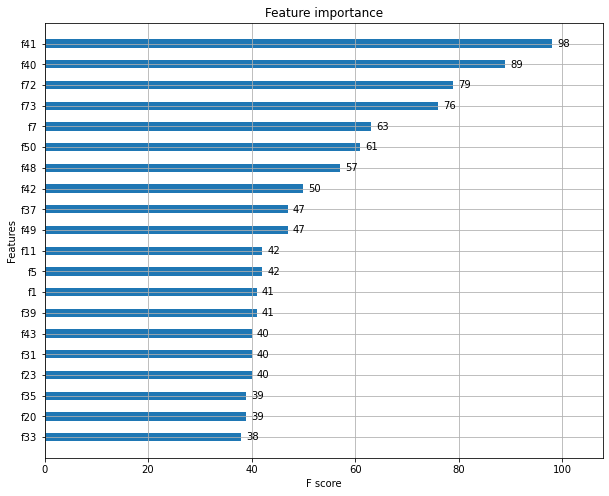

In [14]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)